<a href="https://colab.research.google.com/github/yugonojima/YOLO_practice/blob/main/yolo_ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!uname -a

Linux 6d1597e7ab63 5.4.188+ #1 SMP Sun Apr 24 10:03:06 PDT 2022 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Related Libraries
!apt-get -y install protobuf-compiler python-pil python-lxml python-tk
!pip install matplotlib

# Git clone
!git clone https://github.com/tensorflow/models.git
import os
os.chdir("/content/models")
# !git checkout 7f351c62f8e6c6789d76237bfdc43630714b9b8d

# Set PATH
os.chdir("/content/models/research/")
import sys
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/slim')
sys.path.append('/content/models/research/object_detection')

In [4]:
os.chdir("/content/models/research/")
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!python setup.py build #インストールに必要なものを全てビルドする

In [ ]:
!python setup.py install

In [ ]:
#slimは画像分類系のモデルが実装されているコード
os.chdir("/content/models/research/slim")
!python setup.py build
!python setup.py install

os.chdir("/content/models/research")
!python object_detection/builders/model_builder_test.py

In [ ]:
#学習済みモデルのインストール
os.chdir('/content/models/research/object_detection/')
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz #ファイルを圧縮してダウンロード
!tar -xzvf ssd_mobilenet_v1_coco_2017_11_17.tar.gz #圧縮されたアーカイブを展開する

In [22]:
import numpy as np
import sys
import os
%tensorflow_version 1.x
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from utils import label_map_util
from utils import visualization_utils as vis_util

# モデル読み込み
# TensorflowではTensor(データ)とOperation(計算)から構成されるGraphとしてCNN演算を表現します

# graphオブジェクト生成
detection_graph = tf.Graph() 

# 生成したgraphのコンテキストマネージャを取得
with detection_graph.as_default():
  # graph定義のためのオブジェクトを作成
  od_graph_def = tf.compat.v1.GraphDef()
  
  # モデルファイル(protocol buffer形式)を指定してロード
  with tf.io.gfile.GFile('ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb', 'rb') as fid:
    # バイナリファイルにシリアライズされたgraphデータを読み込み
    serialized_graph = fid.read()
    # graph構造をparseしてオブジェクトに設定
    od_graph_def.ParseFromString(serialized_graph)
    # graphオブジェクトのdefault_graphに追加
    tf.import_graph_def(od_graph_def, name='')

TensorFlow is already loaded. Please restart the runtime to change versions.


In [10]:
# ラベルマップの読み込み

# ラベルマップは、分類カテゴリのkey名とidを関連付ける辞書データ(name,id,display_name)
# 例：CNNの出力が"5"の場合"飛行機"に相当する、など
label_map = label_map_util.load_labelmap('data/mscoco_label_map.pbtxt')

# ラベルマップからカテゴリストを取得(id,display_nameのリスト)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)

# カテゴリidを入力としてkey名を取得するための辞書を作成
category_index = label_map_util.create_category_index(categories)

# 画像データを[width,height,3]次元のnumpy配列に変換
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# 入力画像のディレクトリを指定
PATH_TO_TEST_IMAGES_DIR = 'test_images'
# 入力画像のパスを取得
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 
                                  'image{}.jpg'.format(i)) for i in range(1, 3) ]
# 表示する画像のサイズを指定
IMAGE_SIZE = (18, 12)

In [11]:
!ls test_images/

image1.jpg  image2.jpg	image_info.txt


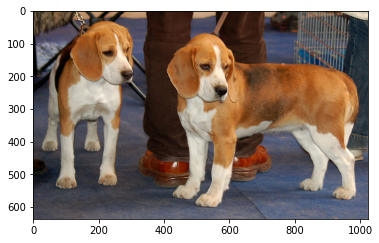

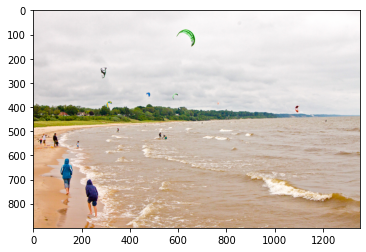

In [23]:
im = Image.open('./test_images/image1.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

im = Image.open('./test_images/image2.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()  

In [19]:
# SSD推論処理の実装
# 引数：numpy形式の画像データ, 学習済みモデルのgraph
def run_inference_for_single_image(image, graph):
  # default_graphを呼び出し
  with graph.as_default():
    # graphのSessionを取得
    # SessionはgraphのOperationsをGPUなどのデバイスに配置し実行する手段を提供
    with tf.compat.v1.Session() as sess:
      # Operation一覧を取得
      ops = tf.compat.v1.get_default_graph().get_operations()
      # Operationの出力Tensorの名前を取得
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      
      # Tensor辞書を生成
      tensor_dict = {}
      for key in [
          'num_detections',    # batchの中で検出されたboxの個数
          'detection_boxes',   # 検出されたboxの座標
          'detection_scores',  # 検出されたboxのスコア
          'detection_classes', # 検出されたboxの分類クラス
      ]:
        tensor_name = key + ':0' # 0番目の出力
        
        # 各key名がOperationの出力に含まれている場合
        if tensor_name in all_tensor_names:
          # key名に相当するTensorを学習済みモデルから取得してTensor辞書に登録
          tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(
              tensor_name)
      
      # image_tensorのkey名をもつTensorを学習済みモデルから取得
      image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

      # 推論処理実行
      output_dict = sess.run(
                tensor_dict, # 取得したいTensorを指定
                feed_dict={image_tensor: np.expand_dims(image, 0)}) # image_tensorの次元を[1,None,None,3]に変換

      # SSDの出力は全てfloat32なので適切な型に変換
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      
  # SSDの出力から取得したTensorを返す
  return output_dict

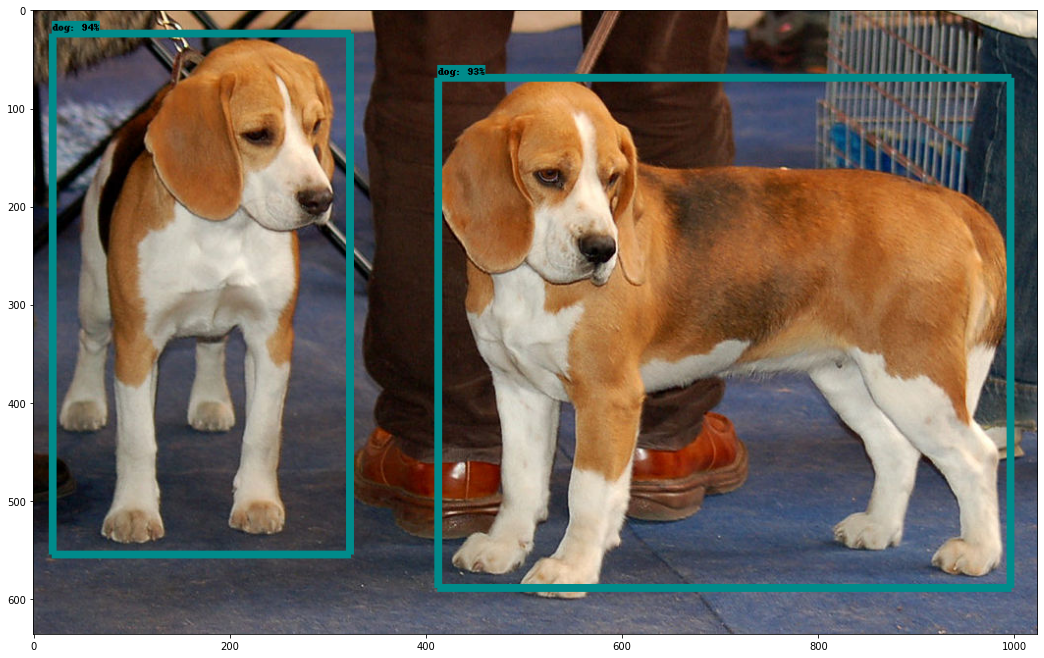

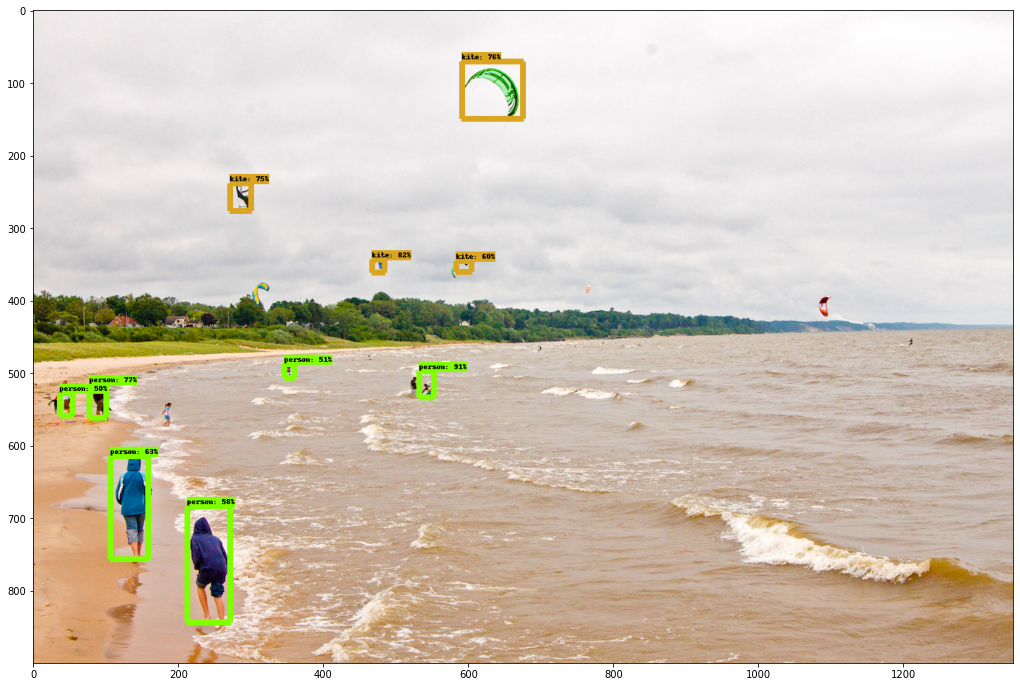

In [24]:
# SSD推論処理の実行

# テスト画像パス読み込み
for image_path in TEST_IMAGE_PATHS:
  # 画像の読み込み
  image = Image.open(image_path)
  # 画像をnumpy配列に変換
  image_np = load_image_into_numpy_array(image)
  # 画像データの0次元目を追加(バッチ分の次元)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # 推論処理の実行
  # 戻り値として辞書に登録したkeyの出力を得る
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # ユーティリティ関数を使用して可視化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,                                         # numpy配列の画像データ
      output_dict['detection_boxes'],   # 検出されたbbox
      output_dict['detection_classes'], # 検出されたbboxのクラス
      output_dict['detection_scores'],  # 検出されたbboxのスコア
      category_index,                               # カテゴリidとカテゴリ名の辞書　
      instance_masks=None,                   # segmentation用マスク（今回は不使用）
      use_normalized_coordinates=True, # 画像サイズで規格化されたbbox位置(ymin, xmin, ymax, xmax)
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [25]:
# output_dictを個々に出力
# 例：スコアが0.5以上の検出結果
(x,y,c) = np.shape(image_np)

for i in range(len(output_dict['detection_classes'])):
  if output_dict['detection_scores'][i] > 0.5:
    print(category_index[output_dict['detection_classes'][i]]['name'],  # 検出されたクラス名
         output_dict['detection_scores'][i], # スコアの値
         np.array(output_dict['detection_boxes'][i].tolist()*np.array([x,y,x,y]), dtype='int')) # 画像上のbox座標

person 0.9168785 [498 532 533 553]
kite 0.82944566 [344 467 361 485]
person 0.77850574 [516  77 561 101]
kite 0.76998615 [ 71 591 149 676]
kite 0.75553906 [239 271 276 301]
person 0.6342339 [615 106 756 159]
kite 0.6074058 [346 583 360 605]
person 0.58910155 [684 212 843 272]
person 0.5123765 [488 346 506 361]
person 0.5014633 [528  36 558  55]


In [ ]:
# os.chdir('/content/models/research/object_detection/')
# !wget https://drive.google.com/file/d/12UdTlb-v5qf2CMF9YXAqH3mgETuRNXKB/view?usp=sharing

In [28]:
files = os.listdir("/content/drive/MyDrive/pictures/")
print(files)

['cell.heic', 'cell.jpg']


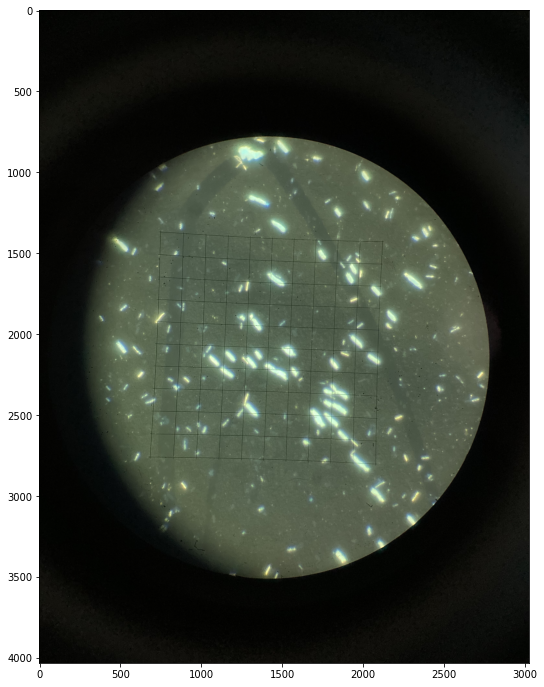

In [29]:
if 1:
  # 画像の読み込み
  image = Image.open('/content/drive/MyDrive/pictures/cell.jpg')
  # 画像をnumpy配列に変換
  image_np = load_image_into_numpy_array(image)
  # 画像データの0次元目を追加(バッチ分の次元)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # 推論処理の実行
  # 戻り値として辞書に登録したkeyの出力を得る
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # ユーティリティ関数を使用して可視化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,                                         # numpy配列の画像データ
      output_dict['detection_boxes'],   # 検出されたbbox
      output_dict['detection_classes'], # 検出されたbboxのクラス
      output_dict['detection_scores'],  # 検出されたbboxのスコア
      category_index,                               # カテゴリidとカテゴリ名の辞書　
      instance_masks=None,                   # segmentation用マスク（今回は不使用）
      use_normalized_coordinates=True, # 画像サイズで規格化されたbbox位置(ymin, xmin, ymax, xmax)
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [30]:
# output_dictを個々に出力
# 例：スコアが0.5以上の検出結果
(x,y,c) = np.shape(image_np)

for i in range(len(output_dict['detection_classes'])):
  if output_dict['detection_scores'][i] > 0.5:
    print(category_index[output_dict['detection_classes'][i]]['name'],  # 検出されたクラス名
         output_dict['detection_scores'][i], # スコアの値
         np.array(output_dict['detection_boxes'][i].tolist()*np.array([x,y,x,y]), dtype='int')) # 画像上のbox座標